In [1]:
from datasets import load_dataset
import numpy as np
from dialog2graph.pipelines.core.graph import Graph
from dialog2graph.pipelines.core.dialog import Dialog

/home/olshevskaya/miniconda3/envs/conda_env_py311/lib/python3.11/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "validate" in "Dialog" shadows an attribute in parent "BaseModel"
  warnings.warn(


In [2]:
dataset = load_dataset("DeepPavlov/d2g_generated_augmented", token=True)
dataset

DatasetDict({
    train: Dataset({
        features: ['graph', 'topic', 'dialogs', 'augmented_dialogs'],
        num_rows: 376
    })
})

In [3]:
example = dataset['train'][0]
graph = Graph(example['graph'])
augmented_dialogs = [Dialog.from_list(**aug_dia) for aug_dia in example['augmented_dialogs']]
len(augmented_dialogs)

18

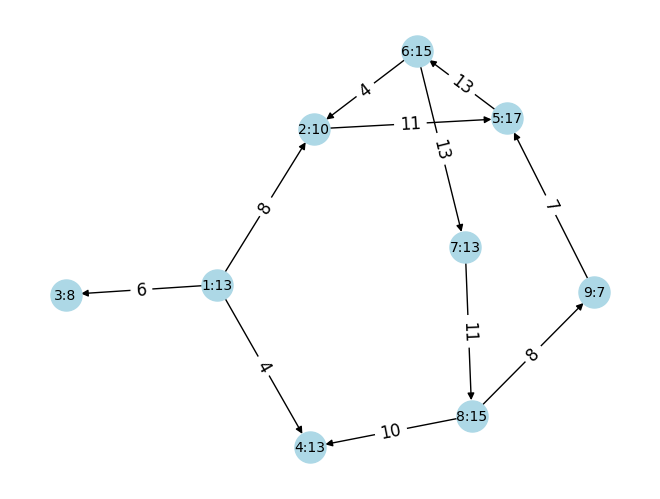

In [5]:
graph.visualise_short('')

In [4]:
def dialogs_to_paths(graph, augmented_dialogs):
    # add id to each edge
    for edge in graph.graph_dict['edges']:
        edge_id = str(edge['source']) + '_' + str(edge['target'])
        edge['id'] = edge_id

    all_paths = []
    for i, aug_dia in enumerate(augmented_dialogs):
        path = {}
        path['nodes'] = []
        path['edges'] = []

        for turn in aug_dia.messages:
            if turn.participant == 'assistant':
                key = 'nodes'
            elif turn.participant == 'user':
                key = 'edges'

            for element in graph.graph_dict[key]:
                if turn.text in element['utterances']:
                    path[key].append(element['id'])

        path['nodes'] = set(path['nodes'])
        path['edges'] = set(path['edges'])

        all_paths.append((i, path))     

    return all_paths

In [5]:
def count_unique_elements(all_paths):
    num_unique_elements = []
    for i, path in all_paths:
        unique_elements = path['nodes'].union(path['edges'])
        num_unique_elements.append((i, len(unique_elements)))
    return num_unique_elements

In [6]:
def get_start_idx(num_unique_elements, all_paths):
    max_unique_elements = np.max([unique_elements for _, unique_elements in num_unique_elements])
    if max_unique_elements == 0:
        return (None, f'Error: no elements in the paths')
    
    idx_to_choose_from = []
    for i, unique_elements in num_unique_elements:
        if unique_elements == max_unique_elements:
            idx_to_choose_from.append(i)
    
    if len(idx_to_choose_from) == 1:
        start_idx = idx_to_choose_from[0]
    else:
        start_idx = int(np.random.choice(idx_to_choose_from))
    
    for i, path in all_paths:
        if i == start_idx:
            start_path = path
            
    return start_idx, start_path

In [7]:
def count_new_elements(path_1, path_2):
    new_nodes = set(path_2['nodes']).difference(set(path_1['nodes']))
    new_edges = set(path_2['edges']).difference(set(path_1['edges']))
    new_elements = len(new_nodes) + len(new_edges)
    return new_elements

In [8]:
def get_new_elements_per_path(all_paths, added_idx, combined_path):
    new_elements_per_path = []    

    for i, path in all_paths:
        if i in added_idx:
            continue
        else:
            new_elements = count_new_elements(combined_path, path)        
            new_elements_per_path.append((i, new_elements)) 
    
    return new_elements_per_path

In [9]:
def get_idx_and_path_to_add(all_paths, added_idx, new_elements_per_path):
    max_new_elements = np.max([new_elements for _, new_elements in new_elements_per_path])
    if max_new_elements == 0:
        return (None, f'no new elements in remaining dialogs')
    
    idx_to_choose_from = []
    for i, new_elements in new_elements_per_path:
        if i in added_idx:
            continue
        else:
            if new_elements == max_new_elements:
                idx_to_choose_from.append(i)
    
    if len(idx_to_choose_from) == 1:
        idx_to_add = idx_to_choose_from[0]
    else:
        idx_to_add = int(np.random.choice(idx_to_choose_from))

    for i, path in all_paths:
        if i == idx_to_add:
            path_to_add = path
                
    return idx_to_add, path_to_add

In [10]:
def get_idx_and_path_to_add_2(all_paths, added_idx, new_elements_per_path):
    max_new_elements = np.max([new_elements for _, new_elements in new_elements_per_path])
    if max_new_elements == 0:
        return (None, f'no new elements in remaining dialogs')
    
    idx_to_choose_from = []
    for i, new_elements in new_elements_per_path:
        if i in added_idx:
            continue
        else:
            if new_elements == max_new_elements:
                idx_to_choose_from.append(i)
    
    paths_to_add = []
    for i, path in all_paths:
        if i in idx_to_choose_from:
            paths_to_add.append(path)
                
    return idx_to_choose_from, paths_to_add

In [11]:
def add_new_elements_to_combined_path(combined_path, new_elements):
    combined_path['nodes'] = combined_path['nodes'].union(new_elements['nodes'])
    combined_path['edges'] = combined_path['edges'].union(new_elements['edges'])
    return combined_path

In [12]:
def remove_dialogs_with_same_path(all_paths, added_idx, path_to_compare_with):
    idx_to_remove = []
    for i, path in all_paths:
        if i in added_idx:
            continue
        else:
            if path == path_to_compare_with:
                idx_to_remove.append(i)
    
    while len(idx_to_remove) > 0:
        for i, path in all_paths:
            if i in idx_to_remove:
                all_paths.remove((i, path))
                
                idx_to_remove.remove(i)
    return all_paths

In [13]:
def get_minimal_needed_dialogs(graph, augmented_dialogs):
    all_paths = dialogs_to_paths(graph, augmented_dialogs)
    num_unique_elements = count_unique_elements(all_paths)
    start_idx, start_path = get_start_idx(num_unique_elements, all_paths)

    added_idx = []
    added_idx.append(start_idx)
    combined_path = start_path.copy()
    print(f'Start dialog {start_idx} was added.')
    
    for i in range(len(augmented_dialogs)):
        new_elements_per_path = get_new_elements_per_path(all_paths, added_idx, combined_path)
        idx_to_add, path_to_add = get_idx_and_path_to_add(all_paths, added_idx, new_elements_per_path)

        if path_to_add == 'no new elements in remaining dialogs':
            print(f'Iteration {i} - {path_to_add}.')
            break
        else: 
            added_idx.append(idx_to_add)
            combined_path = add_new_elements_to_combined_path(combined_path, path_to_add)
            all_paths = remove_dialogs_with_same_path(all_paths, added_idx, path_to_add)
            print(f'Iteration {i} - dialog {idx_to_add} was added.')

    new_augmented_dialogs = []
    for idx in added_idx:
        new_augmented_dialogs.append(augmented_dialogs[idx])

    return new_augmented_dialogs

In [14]:
new_augmented_dialogs = get_minimal_needed_dialogs(graph, augmented_dialogs)
new_augmented_dialogs

Start dialog 3 was added.
Iteration 0 - dialog 11 was added.
Iteration 1 - dialog 6 was added.
Iteration 2 - dialog 16 was added.
Iteration 3 - no new elements in remaining dialogs.


[Dialog(messages=[DialogMessage(text='Hello! How can I help you today?', participant='assistant'), DialogMessage(text='I’d like to place an order.', participant='user'), DialogMessage(text='Awesome! Which product are you looking to buy?', participant='assistant'), DialogMessage(text="I'm interested in a t-shirt.", participant='user'), DialogMessage(text='What size do you need?', participant='assistant'), DialogMessage(text='A medium size, please.', participant='user'), DialogMessage(text='Would you prefer that in red or blue?', participant='assistant'), DialogMessage(text='Red would be perfect.', participant='user'), DialogMessage(text='Great choice! Can I get your shipping address?', participant='assistant'), DialogMessage(text="It's 123 Main Street.", participant='user'), DialogMessage(text='Thanks! Your order is confirmed. Is there anything else I can assist you with?', participant='assistant'), DialogMessage(text='Actually, I’d like to change something in my order.', participant='u

# similarity

In [98]:
all_paths = dialogs_to_paths(graph, augmented_dialogs)
num_unique_elements = count_unique_elements(all_paths)
start_idx, start_path = get_start_idx(num_unique_elements, all_paths)

added_idx = []
added_idx.append(start_idx)
combined_path = start_path.copy()
added_idx, combined_path

([1],
 {'nodes': {1, 2, 4, 5, 6, 7, 8, 9},
  'edges': {'1_2', '2_5', '5_6', '6_7', '7_8', '8_4', '8_9', '9_5'}})

In [99]:
all_paths = remove_dialogs_with_same_path(all_paths, added_idx, start_path)
all_paths

[(1,
  {'nodes': {1, 2, 4, 5, 6, 7, 8, 9},
   'edges': {'1_2', '2_5', '5_6', '6_7', '7_8', '8_4', '8_9', '9_5'}}),
 (6,
  {'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}}),
 (7,
  {'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}}),
 (8,
  {'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}}),
 (9, {'nodes': {1, 3}, 'edges': {'1_3'}}),
 (10, {'nodes': {1, 3}, 'edges': {'1_3'}}),
 (11, {'nodes': {1, 3}, 'edges': {'1_3'}}),
 (12, {'nodes': {1, 3}, 'edges': {'1_3'}}),
 (13, {'nodes': {1, 3}, 'edges': {'1_3'}}),
 (14, {'nodes': {1, 3}, 'edges': {'1_3'}}),
 (15, {'nodes': {1, 4}, 'edges': {'1_4'}}),
 (16, {'nodes': {1, 4}, 'edges': {'1_4'}}),
 (17, {'nodes': {1, 4}, 'edges': {'1_4'}})]

In [17]:
new_elements_per_path = get_new_elements_per_path(all_paths, added_idx, combined_path)
new_elements_per_path

[(6, 1),
 (7, 1),
 (8, 1),
 (9, 2),
 (10, 2),
 (11, 2),
 (12, 2),
 (13, 2),
 (14, 2),
 (15, 1),
 (16, 1),
 (17, 1)]

In [18]:
idx_to_choose_from, paths_to_add = get_idx_and_path_to_add_2(all_paths, added_idx, new_elements_per_path)
idx_to_choose_from, paths_to_add

([9, 10, 11, 12, 13, 14],
 [{'nodes': {1, 3}, 'edges': {'1_3'}},
  {'nodes': {1, 3}, 'edges': {'1_3'}},
  {'nodes': {1, 3}, 'edges': {'1_3'}},
  {'nodes': {1, 3}, 'edges': {'1_3'}},
  {'nodes': {1, 3}, 'edges': {'1_3'}},
  {'nodes': {1, 3}, 'edges': {'1_3'}}])

In [20]:
# find all new elements between combined_path and each path_to_add
# make it a set to remove duplicates
common_elements = []
for path in paths_to_add:
    common_nodes = path['nodes'].intersection(combined_path['nodes'])
    common_edges = path['edges'].intersection(combined_path['edges'])
    common_elements += list(common_nodes.union(common_edges))
common_elements = set(common_elements)
common_elements

{1}

In [50]:
# collect all uttrs for each common_element (from the graph)
common_elements_uttr = {}
for el in common_elements:
    if isinstance(el, int):
        key = 'nodes'
    elif isinstance(el, str):
        key = 'edges'
    
    for graph_el in graph.graph_dict[key]:
        if graph_el['id'] == el:
            common_elements_uttr[el] = {'utterances' : set(graph_el['utterances'])}
common_elements_uttr

{1: {'utterances': {'Hello! How can I help you today?',
   'Hello! What can I do for you today?',
   'Hello! What can I help you with today?',
   'Hey there! How may I assist you today?',
   'Hey there! How may I assist you?',
   'Hey there! What assistance do you need today?',
   'Hey there! What can I do for you today?',
   'Hey! How may I help you today?',
   'Hi there! How can I assist you today?',
   'Hi! Is there something I can assist you with today?',
   'Hi! What assistance do you need today?',
   'Hi! What can I do for you today?',
   'Hi! What do you need help with today?'}}}

In [51]:
# find golden uttr
for el in common_elements_uttr:
    if isinstance(el, int):
        key = 'assistant'
    elif isinstance(el, str):
        key = 'user'
    
    for turn in augmented_dialogs[start_idx].messages:
        if turn.participant == key and turn.text in common_elements_uttr[el]['utterances']:
            common_elements_uttr[el]['golden_uttr'] = turn.text
    
common_elements_uttr

{1: {'utterances': {'Hello! How can I help you today?',
   'Hello! What can I do for you today?',
   'Hello! What can I help you with today?',
   'Hey there! How may I assist you today?',
   'Hey there! How may I assist you?',
   'Hey there! What assistance do you need today?',
   'Hey there! What can I do for you today?',
   'Hey! How may I help you today?',
   'Hi there! How can I assist you today?',
   'Hi! Is there something I can assist you with today?',
   'Hi! What assistance do you need today?',
   'Hi! What can I do for you today?',
   'Hi! What do you need help with today?'},
  'golden_uttr': 'Hi! What assistance do you need today?'}}

In [52]:
idx_to_choose_from

[9, 10, 11, 12, 13, 14]

In [53]:
# collect uttr_for_comparison
for el in common_elements_uttr:
    if isinstance(el, int):
        key = 'assistant'
    elif isinstance(el, str):
        key = 'user'
    
    uttr_for_comparison = []
    for idx in idx_to_choose_from:
        for turn in augmented_dialogs[idx].messages:
            if turn.participant == key and turn.text in common_elements_uttr[el]['utterances']:
                uttr_for_comparison.append([idx, turn.text])

    common_elements_uttr[el]['uttr_for_comparison'] = uttr_for_comparison
    common_elements_uttr[el].pop('utterances')
common_elements_uttr

{1: {'golden_uttr': 'Hi! What assistance do you need today?',
  'uttr_for_comparison': [[9, 'Hello! What can I do for you today?'],
   [10, 'Hey! How may I help you today?'],
   [11, 'Hi! What assistance do you need today?'],
   [12, 'Hello! What can I help you with today?'],
   [13, 'Hey there! How may I assist you today?'],
   [14, 'Hi! What do you need help with today?']]}}

In [25]:
from dialog2graph.metrics.similarity import get_similarity

In [54]:
for el in common_elements_uttr:
    golden = [common_elements_uttr[el]['golden_uttr']]
    generated = [uttr for _, uttr in common_elements_uttr[el]['uttr_for_comparison']]
    similarities = get_similarity(golden=golden, generated=generated)

    for data, sim in zip(common_elements_uttr[el]['uttr_for_comparison'], similarities):
        data.append(sim[0])
common_elements_uttr     

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{1: {'golden_uttr': 'Hi! What assistance do you need today?',
  'uttr_for_comparison': [[9,
    'Hello! What can I do for you today?',
    np.float32(0.88490856)],
   [10, 'Hey! How may I help you today?', np.float32(0.9098406)],
   [11, 'Hi! What assistance do you need today?', np.float32(1.0)],
   [12, 'Hello! What can I help you with today?', np.float32(0.92409873)],
   [13, 'Hey there! How may I assist you today?', np.float32(0.92060506)],
   [14, 'Hi! What do you need help with today?', np.float32(0.97558707)]]}}

In [55]:
common_elements_uttr = {
    1: {'golden_uttr': 'Hi! What assistance do you need today?',
  'uttr_for_comparison': [[9,
    'Hello! What can I do for you today?',
    np.float32(0.8849076)],
   [10, 'Hey! How may I help you today?', np.float32(0.90984046)],
   [11, 'Hi! What assistance do you need today?', np.float32(1.0000001)],
   [12, 'Hello! What can I help you with today?', np.float32(0.92409885)],
   [13, 'Hey there! How may I assist you today?', np.float32(0.92060506)],
   [14, 'Hi! What do you need help with today?', np.float32(0.97558695)]]},
   2: {'golden_uttr': 'Hi! What assistance do you need today?',
  'uttr_for_comparison': [[9,
    'Hello! What can I do for you today?',
    np.float32(0.8849076)],
   [10, 'Hey! How may I help you today?', np.float32(0.90984046)],
   [11, 'Hi! What assistance do you need today?', np.float32(1.0000001)],
   [12, 'Hello! What can I help you with today?', np.float32(0.92409885)],
   [13, 'Hey there! How may I assist you today?', np.float32(0.92060506)],
   [14, 'Hi! What do you need help with today?', np.float32(0.97558695)]]}
}

In [56]:
dialog_similarities = []
for i in idx_to_choose_from:
    sum_sim = 0
    for el in common_elements_uttr:
        for id, uttr, sim in common_elements_uttr[el]['uttr_for_comparison']:
            if id == i:
                sum_sim += sim
    dialog_similarities.append((i, sum_sim))
dialog_similarities

[(9, np.float32(1.7698152)),
 (10, np.float32(1.8196809)),
 (11, np.float32(2.0000002)),
 (12, np.float32(1.8481977)),
 (13, np.float32(1.8412101)),
 (14, np.float32(1.9511739))]

In [57]:
dialog_similarities = sorted(dialog_similarities, key=lambda sim: sim[1])
dialog_similarities

[(9, np.float32(1.7698152)),
 (10, np.float32(1.8196809)),
 (13, np.float32(1.8412101)),
 (12, np.float32(1.8481977)),
 (14, np.float32(1.9511739)),
 (11, np.float32(2.0000002))]

In [58]:
idx_to_choose = dialog_similarities[0][0]
idx_to_choose

9

In [60]:
for idx, path in all_paths:
    if idx == idx_to_choose:
        path_to_add = path
path_to_add

{'nodes': {1, 3}, 'edges': {'1_3'}}

In [61]:
combined_path = add_new_elements_to_combined_path(combined_path, path_to_add)
combined_path

{'nodes': {1, 2, 3, 4, 5, 6, 7, 8, 9},
 'edges': {'1_2', '1_3', '2_5', '5_6', '6_7', '7_8', '8_4', '8_9', '9_5'}}

In [62]:
added_idx.append(idx_to_choose)
all_paths = remove_dialogs_with_same_path(all_paths, added_idx, path_to_add)
all_paths

[(5,
  {'nodes': {1, 2, 4, 5, 6, 7, 8, 9},
   'edges': {'1_2', '2_5', '5_6', '6_7', '7_8', '8_4', '8_9', '9_5'}}),
 (6,
  {'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}}),
 (7,
  {'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}}),
 (8,
  {'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}}),
 (9, {'nodes': {1, 3}, 'edges': {'1_3'}}),
 (15, {'nodes': {1, 4}, 'edges': {'1_4'}}),
 (16, {'nodes': {1, 4}, 'edges': {'1_4'}}),
 (17, {'nodes': {1, 4}, 'edges': {'1_4'}})]

ROUND 2

In [116]:
new_elements_per_path = get_new_elements_per_path(all_paths, added_idx, combined_path)
new_elements_per_path

[(6, 1), (7, 1), (8, 1), (15, 1), (16, 1), (17, 1)]

In [117]:
idx_to_choose_from, paths_to_add = get_idx_and_path_to_add_2(all_paths, added_idx, new_elements_per_path)
idx_to_choose_from, paths_to_add

([6, 7, 8, 15, 16, 17],
 [{'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}},
  {'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}},
  {'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}},
  {'nodes': {1, 4}, 'edges': {'1_4'}},
  {'nodes': {1, 4}, 'edges': {'1_4'}},
  {'nodes': {1, 4}, 'edges': {'1_4'}}])

In [118]:
def find_common_elements(combined_path, paths_to_add):
    # find all COMMON elements between combined_path and each path_to_add
    # make it a set to remove duplicates
    common_elements = []
    for path in paths_to_add:
        common_nodes = path['nodes'].intersection(combined_path['nodes'])
        common_edges = path['edges'].intersection(combined_path['edges'])
        common_elements += list(common_nodes.union(common_edges))
    common_elements = set(common_elements)
    
    return common_elements

In [119]:
common_elements = find_common_elements(combined_path, paths_to_add)
common_elements

{1, '1_2', 2, '2_5', 4, 5, '5_6', 6, '6_7', 7, '7_8', 8, '8_4'}

In [120]:
def get_uttrs_for_common_elements(common_elements, graph):
    # collect all uttrs for each common_element (from the graph)
    common_elements_uttr = {}
    for el in common_elements:
        if isinstance(el, int):
            key = 'nodes'
        elif isinstance(el, str):
            key = 'edges'
        
        for graph_el in graph.graph_dict[key]:
            if graph_el['id'] == el:
                common_elements_uttr[el] = {'utterances' : set(graph_el['utterances'])}
                
    return common_elements_uttr

In [121]:
common_elements_uttr = get_uttrs_for_common_elements(common_elements, graph)
common_elements_uttr

{1: {'utterances': {'Hello! How can I help you today?',
   'Hello! What can I do for you today?',
   'Hello! What can I help you with today?',
   'Hey there! How may I assist you today?',
   'Hey there! How may I assist you?',
   'Hey there! What assistance do you need today?',
   'Hey there! What can I do for you today?',
   'Hey! How may I help you today?',
   'Hi there! How can I assist you today?',
   'Hi! Is there something I can assist you with today?',
   'Hi! What assistance do you need today?',
   'Hi! What can I do for you today?',
   'Hi! What do you need help with today?'}},
 2: {'utterances': {'Awesome! Which product are you interested in?',
   'Awesome! Which product are you looking to buy?',
   'Fantastic! What item are you interested in?',
   'Got it! What are you interested in ordering?',
   'Great! What product are you interested in?',
   'Great! What would you like to order?',
   'No problem! What would you like to order instead?',
   'Sounds good! What item do you h

In [122]:
def find_golden_uttr(common_elements_uttr, added_idx, augmented_dialogs):
    # find golden uttr
    for el in common_elements_uttr:
        if isinstance(el, int):
            key = 'assistant'
        elif isinstance(el, str):
            key = 'user'
        
        common_elements_uttr[el]['golden_uttr'] = []
        
        for idx in added_idx:
            for turn in augmented_dialogs[idx].messages:
                if turn.participant == key and turn.text in common_elements_uttr[el]['utterances']:
                    common_elements_uttr[el]['golden_uttr'].append(turn.text)
        
    return common_elements_uttr

In [123]:
common_elements_uttr = find_golden_uttr(common_elements_uttr, added_idx, augmented_dialogs)
common_elements_uttr

{1: {'utterances': {'Hello! How can I help you today?',
   'Hello! What can I do for you today?',
   'Hello! What can I help you with today?',
   'Hey there! How may I assist you today?',
   'Hey there! How may I assist you?',
   'Hey there! What assistance do you need today?',
   'Hey there! What can I do for you today?',
   'Hey! How may I help you today?',
   'Hi there! How can I assist you today?',
   'Hi! Is there something I can assist you with today?',
   'Hi! What assistance do you need today?',
   'Hi! What can I do for you today?',
   'Hi! What do you need help with today?'},
  'golden_uttr': ['Hey there! What assistance do you need today?',
   'Hello! What can I do for you today?']},
 2: {'utterances': {'Awesome! Which product are you interested in?',
   'Awesome! Which product are you looking to buy?',
   'Fantastic! What item are you interested in?',
   'Got it! What are you interested in ordering?',
   'Great! What product are you interested in?',
   'Great! What would yo

In [124]:
def get_uttrs_for_comparison(common_elements_uttr, idx_to_choose_from, augmented_dialogs):
    # collect uttr_for_comparison
    for el in common_elements_uttr:
        if isinstance(el, int):
            key = 'assistant'
        elif isinstance(el, str):
            key = 'user'
        
        uttr_for_comparison = []
        for idx in idx_to_choose_from:
            for turn in augmented_dialogs[idx].messages:
                if turn.participant == key and turn.text in common_elements_uttr[el]['utterances']:
                    uttr_for_comparison.append([idx, turn.text])

        common_elements_uttr[el]['uttr_for_comparison'] = uttr_for_comparison
        common_elements_uttr[el].pop('utterances')

    return common_elements_uttr

In [125]:
common_elements_uttr = get_uttrs_for_comparison(common_elements_uttr, idx_to_choose_from, augmented_dialogs)
common_elements_uttr

{1: {'golden_uttr': ['Hey there! What assistance do you need today?',
   'Hello! What can I do for you today?'],
  'uttr_for_comparison': [[6, 'Hello! How can I help you today?'],
   [7, 'Hi! What can I do for you today?'],
   [8, 'Hey there! How may I assist you?'],
   [15, 'Hello! What can I help you with today?'],
   [16, 'Hey there! How may I assist you?'],
   [17, 'Hi! What do you need help with today?']]},
 2: {'golden_uttr': ['Sounds good! What item do you want to order?'],
  'uttr_for_comparison': [[6,
    'Awesome! Which product are you looking to buy?'],
   [6, 'No problem! What would you like to order instead?'],
   [7, 'Sounds good! What item do you have in mind?'],
   [7, 'Sure thing! What product do you want now?'],
   [8, 'Great! What would you like to order?'],
   [8, 'Got it! What are you interested in ordering?']]},
 '2_5': {'golden_uttr': ["I'm interested in a t-shirt."],
  'uttr_for_comparison': [[6, 'I want a t-shirt.'],
   [6, 'I want a t-shirt again.'],
   [7, 'I

In [127]:
def get_uttr_similarity(common_elements_uttr):
    for el in common_elements_uttr:
        golden = common_elements_uttr[el]['golden_uttr']
        generated = [uttr for _, uttr in common_elements_uttr[el]['uttr_for_comparison']]
        similarities = get_similarity(golden=golden, generated=generated)

        for data, sim in zip(common_elements_uttr[el]['uttr_for_comparison'], similarities):
            data.append(sim[0])

    return common_elements_uttr

In [128]:
common_elements_uttr = get_uttr_similarity(common_elements_uttr)
common_elements_uttr

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{1: {'golden_uttr': ['Hey there! What assistance do you need today?',
   'Hello! What can I do for you today?'],
  'uttr_for_comparison': [[6,
    'Hello! How can I help you today?',
    np.float32(0.9173337)],
   [7, 'Hi! What can I do for you today?', np.float32(0.88620317)],
   [8, 'Hey there! How may I assist you?', np.float32(0.8750465)],
   [15, 'Hello! What can I help you with today?', np.float32(0.9241396)],
   [16, 'Hey there! How may I assist you?', np.float32(0.8750437)],
   [17, 'Hi! What do you need help with today?', np.float32(0.9658518)]]},
 2: {'golden_uttr': ['Sounds good! What item do you want to order?'],
  'uttr_for_comparison': [[6,
    'Awesome! Which product are you looking to buy?',
    np.float32(0.8211713)],
   [6,
    'No problem! What would you like to order instead?',
    np.float32(0.8093132)],
   [7, 'Sounds good! What item do you have in mind?', np.float32(0.8906335)],
   [7, 'Sure thing! What product do you want now?', np.float32(0.8063383)],
   [8, 'G

In [108]:
for el in common_elements_uttr:
    golden = common_elements_uttr[el]['golden_uttr']
    generated = [uttr for _, uttr in common_elements_uttr[el]['uttr_for_comparison']]
    similarities = get_similarity(golden=golden, generated=generated)

    for data, sim in zip(common_elements_uttr[el]['uttr_for_comparison'], similarities):
        data.append(sim[0])
common_elements_uttr     

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{1: {'golden_uttr': ['Hey there! What assistance do you need today?'],
  'uttr_for_comparison': [[9,
    'Hello! What can I do for you today?',
    np.float32(0.88599485)],
   [10, 'Hey! How may I help you today?', np.float32(0.9128748)],
   [11, 'Hi! What assistance do you need today?', np.float32(0.9892097)],
   [12, 'Hello! What can I help you with today?', np.float32(0.92413944)],
   [13, 'Hey there! How may I assist you today?', np.float32(0.93333125)],
   [14, 'Hi! What do you need help with today?', np.float32(0.9658518)]]}}

In [131]:
def get_dialog_similarity(common_elements_uttr, idx_to_choose_from):
    dialog_similarities = []
    for i in idx_to_choose_from:
        sum_sim = 0
        for el in common_elements_uttr:
            for id, uttr, sim in common_elements_uttr[el]['uttr_for_comparison']:
                if id == i:
                    sum_sim += sim
        dialog_similarities.append((i, sum_sim))
        dialog_similarities = sorted(dialog_similarities, key=lambda sim: sim[1])
    
    return dialog_similarities

In [132]:
dialog_similarities = get_dialog_similarity(common_elements_uttr, idx_to_choose_from)
dialog_similarities

[(16, np.float32(1.7263621)),
 (17, np.float32(1.7613289)),
 (15, np.float32(1.7728816)),
 (8, np.float32(15.765711)),
 (6, np.float32(16.02154)),
 (7, np.float32(16.34519))]

In [133]:
def get_idx_and_path_to_add_3(dialog_similarities):
    idx_to_add = dialog_similarities[0][0]
    for idx, path in all_paths:
        if idx == idx_to_choose:
            path_to_add = path

    return idx_to_add, path_to_add

In [134]:
idx_to_add, path_to_add = get_idx_and_path_to_add_3(dialog_similarities)
idx_to_add, path_to_add

(16, {'nodes': {1, 3}, 'edges': {'1_3'}})

In [113]:
combined_path = add_new_elements_to_combined_path(combined_path, path_to_add)
combined_path

{'nodes': {1, 2, 3, 4, 5, 6, 7, 8, 9},
 'edges': {'1_2', '1_3', '2_5', '5_6', '6_7', '7_8', '8_4', '8_9', '9_5'}}

In [114]:
added_idx.append(idx_to_choose)
all_paths = remove_dialogs_with_same_path(all_paths, added_idx, path_to_add)
all_paths

[(1,
  {'nodes': {1, 2, 4, 5, 6, 7, 8, 9},
   'edges': {'1_2', '2_5', '5_6', '6_7', '7_8', '8_4', '8_9', '9_5'}}),
 (6,
  {'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}}),
 (7,
  {'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}}),
 (8,
  {'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}}),
 (9, {'nodes': {1, 3}, 'edges': {'1_3'}}),
 (15, {'nodes': {1, 4}, 'edges': {'1_4'}}),
 (16, {'nodes': {1, 4}, 'edges': {'1_4'}}),
 (17, {'nodes': {1, 4}, 'edges': {'1_4'}})]

ROUND 3

In [115]:
new_elements_per_path = get_new_elements_per_path(all_paths, added_idx, combined_path)
new_elements_per_path

[(6, 1), (7, 1), (8, 1), (15, 1), (16, 1), (17, 1)]

In [83]:
idx_to_choose_from, paths_to_add = get_idx_and_path_to_add_2(all_paths, added_idx, new_elements_per_path)
idx_to_choose_from, paths_to_add

([6, 7, 8],
 [{'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}},
  {'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}},
  {'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}}])

In [84]:
combined_path

{'nodes': {1, 2, 3, 4, 5, 6, 7, 8, 9},
 'edges': {'1_2',
  '1_3',
  '1_4',
  '2_5',
  '5_6',
  '6_7',
  '7_8',
  '8_4',
  '8_9',
  '9_5'}}

In [85]:
# find all COMMON elements between combined_path and each path_to_add
# make it a set to remove duplicates
common_elements = []
for path in paths_to_add:
    common_nodes = path['nodes'].intersection(combined_path['nodes'])
    common_edges = path['edges'].intersection(combined_path['edges'])
    common_elements += list(common_nodes.union(common_edges))
common_elements = set(common_elements)
common_elements

{1, '1_2', 2, '2_5', 4, 5, '5_6', 6, '6_7', 7, '7_8', 8, '8_4'}

In [86]:
# collect all uttrs for each common_element (from the graph)
common_elements_uttr = {}
for el in common_elements:
    if isinstance(el, int):
        key = 'nodes'
    elif isinstance(el, str):
        key = 'edges'
    
    for graph_el in graph.graph_dict[key]:
        if graph_el['id'] == el:
            common_elements_uttr[el] = {'utterances' : set(graph_el['utterances'])}
common_elements_uttr

{1: {'utterances': {'Hello! How can I help you today?',
   'Hello! What can I do for you today?',
   'Hello! What can I help you with today?',
   'Hey there! How may I assist you today?',
   'Hey there! How may I assist you?',
   'Hey there! What assistance do you need today?',
   'Hey there! What can I do for you today?',
   'Hey! How may I help you today?',
   'Hi there! How can I assist you today?',
   'Hi! Is there something I can assist you with today?',
   'Hi! What assistance do you need today?',
   'Hi! What can I do for you today?',
   'Hi! What do you need help with today?'}},
 2: {'utterances': {'Awesome! Which product are you interested in?',
   'Awesome! Which product are you looking to buy?',
   'Fantastic! What item are you interested in?',
   'Got it! What are you interested in ordering?',
   'Great! What product are you interested in?',
   'Great! What would you like to order?',
   'No problem! What would you like to order instead?',
   'Sounds good! What item do you h

In [87]:
# find golden uttr
for el in common_elements_uttr:
    if isinstance(el, int):
        key = 'assistant'
    elif isinstance(el, str):
        key = 'user'
    
    common_elements_uttr[el]['golden_uttr'] = []
    
    for idx in added_idx:
        for turn in augmented_dialogs[idx].messages:
            if turn.participant == key and turn.text in common_elements_uttr[el]['utterances']:
                common_elements_uttr[el]['golden_uttr'].append(turn.text)
    
common_elements_uttr

{1: {'utterances': {'Hello! How can I help you today?',
   'Hello! What can I do for you today?',
   'Hello! What can I help you with today?',
   'Hey there! How may I assist you today?',
   'Hey there! How may I assist you?',
   'Hey there! What assistance do you need today?',
   'Hey there! What can I do for you today?',
   'Hey! How may I help you today?',
   'Hi there! How can I assist you today?',
   'Hi! Is there something I can assist you with today?',
   'Hi! What assistance do you need today?',
   'Hi! What can I do for you today?',
   'Hi! What do you need help with today?'},
  'golden_uttr': ['Hi! What assistance do you need today?',
   'Hello! What can I do for you today?',
   'Hey there! How may I assist you?']},
 2: {'utterances': {'Awesome! Which product are you interested in?',
   'Awesome! Which product are you looking to buy?',
   'Fantastic! What item are you interested in?',
   'Got it! What are you interested in ordering?',
   'Great! What product are you intereste

In [88]:
idx_to_choose_from


[6, 7, 8]

In [89]:
# collect uttr_for_comparison
for el in common_elements_uttr:
    if isinstance(el, int):
        key = 'assistant'
    elif isinstance(el, str):
        key = 'user'
    
    uttr_for_comparison = []
    for idx in idx_to_choose_from:
        for turn in augmented_dialogs[idx].messages:
            if turn.participant == key and turn.text in common_elements_uttr[el]['utterances']:
                uttr_for_comparison.append([idx, turn.text])

    common_elements_uttr[el]['uttr_for_comparison'] = uttr_for_comparison
    common_elements_uttr[el].pop('utterances')
common_elements_uttr

{1: {'golden_uttr': ['Hi! What assistance do you need today?',
   'Hello! What can I do for you today?',
   'Hey there! How may I assist you?'],
  'uttr_for_comparison': [[6, 'Hello! How can I help you today?'],
   [7, 'Hi! What can I do for you today?'],
   [8, 'Hey there! How may I assist you?']]},
 2: {'golden_uttr': ['Great! What would you like to order?'],
  'uttr_for_comparison': [[6,
    'Awesome! Which product are you looking to buy?'],
   [6, 'No problem! What would you like to order instead?'],
   [7, 'Sounds good! What item do you have in mind?'],
   [7, 'Sure thing! What product do you want now?'],
   [8, 'Great! What would you like to order?'],
   [8, 'Got it! What are you interested in ordering?']]},
 '2_5': {'golden_uttr': ["I'd love to order a t-shirt."],
  'uttr_for_comparison': [[6, 'I want a t-shirt.'],
   [6, 'I want a t-shirt again.'],
   [7, 'I would like to order a t-shirt.'],
   [7, 'I’m back to wanting a t-shirt.'],
   [8, "I'm interested in a t-shirt."],
   [8

In [90]:
for el in common_elements_uttr:
    golden = common_elements_uttr[el]['golden_uttr']
    generated = [uttr for _, uttr in common_elements_uttr[el]['uttr_for_comparison']]
    similarities = get_similarity(golden=golden, generated=generated)

    for data, sim in zip(common_elements_uttr[el]['uttr_for_comparison'], similarities):
        data.append(sim[0])
common_elements_uttr     

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{1: {'golden_uttr': ['Hi! What assistance do you need today?',
   'Hello! What can I do for you today?',
   'Hey there! How may I assist you?'],
  'uttr_for_comparison': [[6,
    'Hello! How can I help you today?',
    np.float32(0.9163523)],
   [7, 'Hi! What can I do for you today?', np.float32(0.8923806)],
   [8, 'Hey there! How may I assist you?', np.float32(0.85736316)]]},
 2: {'golden_uttr': ['Great! What would you like to order?'],
  'uttr_for_comparison': [[6,
    'Awesome! Which product are you looking to buy?',
    np.float32(0.8256558)],
   [6,
    'No problem! What would you like to order instead?',
    np.float32(0.81278676)],
   [7, 'Sounds good! What item do you have in mind?', np.float32(0.7675855)],
   [7, 'Sure thing! What product do you want now?', np.float32(0.77405965)],
   [8, 'Great! What would you like to order?', np.float32(0.99999976)],
   [8,
    'Got it! What are you interested in ordering?',
    np.float32(0.84856915)]]},
 '2_5': {'golden_uttr': ["I'd love t

In [91]:
dialog_similarities = []
for i in idx_to_choose_from:
    sum_sim = 0
    for el in common_elements_uttr:
        for id, uttr, sim in common_elements_uttr[el]['uttr_for_comparison']:
            if id == i:
                sum_sim += sim
    dialog_similarities.append((i, sum_sim))
dialog_similarities

[(6, np.float32(16.05426)),
 (7, np.float32(15.485856)),
 (8, np.float32(16.134377))]

In [92]:
dialog_similarities = sorted(dialog_similarities, key=lambda sim: sim[1])
dialog_similarities

[(7, np.float32(15.485856)),
 (6, np.float32(16.05426)),
 (8, np.float32(16.134377))]

In [93]:
idx_to_choose = dialog_similarities[0][0]
idx_to_choose

7

In [94]:
for idx, path in all_paths:
    if idx == idx_to_choose:
        path_to_add = path
path_to_add

{'nodes': {1, 2, 4, 5, 6, 7, 8},
 'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}}

In [95]:
combined_path = add_new_elements_to_combined_path(combined_path, path_to_add)
combined_path

{'nodes': {1, 2, 3, 4, 5, 6, 7, 8, 9},
 'edges': {'1_2',
  '1_3',
  '1_4',
  '2_5',
  '5_6',
  '6_2',
  '6_7',
  '7_8',
  '8_4',
  '8_9',
  '9_5'}}

In [96]:
added_idx.append(idx_to_choose)
all_paths = remove_dialogs_with_same_path(all_paths, added_idx, path_to_add)
all_paths

[(5,
  {'nodes': {1, 2, 4, 5, 6, 7, 8, 9},
   'edges': {'1_2', '2_5', '5_6', '6_7', '7_8', '8_4', '8_9', '9_5'}}),
 (7,
  {'nodes': {1, 2, 4, 5, 6, 7, 8},
   'edges': {'1_2', '2_5', '5_6', '6_2', '6_7', '7_8', '8_4'}}),
 (9, {'nodes': {1, 3}, 'edges': {'1_3'}}),
 (16, {'nodes': {1, 4}, 'edges': {'1_4'}})]

In [97]:
added_idx

[5, 9, 16, 7]

In [ ]:
def get_idx_and_path_to_add_2(all_paths, added_idx, new_elements_per_path):
    max_new_elements = np.max([new_elements for _, new_elements in new_elements_per_path])
    if max_new_elements == 0:
        return (None, f'no new elements in remaining dialogs')
    
    idx_to_choose_from = []
    for i, new_elements in new_elements_per_path:
        if i in added_idx:
            continue
        else:
            if new_elements == max_new_elements:
                idx_to_choose_from.append(i)
    
    paths_to_add = []
    for i, path in all_paths:
        if i in idx_to_choose_from:
            paths_to_add.append(path)
                
    return idx_to_choose_from, paths_to_add